In [1]:
from torch.nn import functional as F

from PIL import Image
from glob import glob
from scipy.io import loadmat

import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import torchvision.transforms.functional as FF

import torch
import torchvision
import os
import random

#### Load the data

In [12]:
class Crowd(data.Dataset):
    def __init__(self, root_path, crop_size, trans, downsample_ratio=8):
        self.root_path = root_path
        self.trans = trans
        self.im_list = sorted(glob(os.path.join(self.root_path, '*.jpg')))
        self.annot_list = sorted(glob(os.path.join(self.root_path, '*.mat')))
        self.c_size = crop_size
        print('number of img: {}'.format(len(self.im_list))) 
        
        plt.hist(([len(loadmat(annot)['annPoints']) for annot in self.annot_list]), bins=24)

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, item):
        img_path = self.im_list[item]
        ann_path = img_path.replace('.jpg', '_ann.mat')
        img = self.train_transform(Image.open(img_path).convert('RGB'))
        keypoints = loadmat(ann_path)['annPoints']
        img = self.trans(img)
        
        if len(keypoints) < 300:
            c = 1
        elif len(keypoints) < 700:
            c = 2
        elif len(keypoints) < 1200:
            c = 3
        elif len(keypoints) < 2300:
            c = 4
        else:
            c = 5

        return img, c

    def train_transform(self, img):
        img = FF.resize(img, (224,224))
        return img

number of img: 1201
number of img: 334


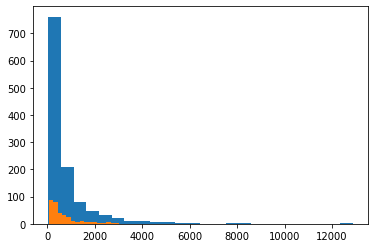

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 2500
learning_rate = 0.001
downsample_ratio=8

pad_size = 9999

transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_dataset = Crowd('data/Train/', pad_size, transformation, downsample_ratio)
test_dataset = Crowd('data/Test/', transformation, downsample_ratio)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#### Build the Model

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        # -> n, 3, 224, 224
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 110, 110
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 53, 53
        x = x.view(-1, 16 * 53 * 53)            # -> n, 44944
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 12816
        return x

#### Training Loop

In [5]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels-1)
        print('loss')
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
torch.Size([1201])
loss
Finished Training


#### Testing Loop

In [17]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        #print(f'Accuracy of {classes[i]}: {acc} %')

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F45B22DFD30>


TypeError: 'int' object is not callable